<div align="center">
  <h1><strong>Hands-On! GWE #7</strong></h1>
</div>

---

## 📊 **Overview Dataset**
Dataset yang digunakan dalam proyek ini diperoleh melalui proses scraping data komentar di TikTok, menggunakan script dari repository GitHub [cubernetes/TikTokCommentScraper](https://github.com/cubernetes/TikTokCommentScraper). File utama yang digunakan dalam proyek ini adalah `tiktok.csv`, yang berisi data komentar TikTok beserta label klasifikasinya. Berikut adalah deskripsi dari kolom-kolom yang ada dalam dataset tersebut:

- **Text**: Kolom ini berisi teks dari komentar yang diambil dari video TikTok. Setiap entri adalah komentar unik dari pengguna TikTok.
- **Label**: Kolom ini berisi label untuk setiap komentar yang menunjukkan apakah komentar tersebut termasuk dalam kategori **Bullying** atau **Non-Bullying**. Label ini berisi nilai biner:
  - **0**: Non-Bullying, menunjukkan bahwa komentar tersebut tidak mengandung bullying.
  - **1**: Bullying, menunjukkan bahwa komentar tersebut mengandung bullying.

In [1]:
# Install Sastrawi dan IndoNLP jika belum ada
!pip install Sastrawi
!pip install indoNLP


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: C:\Users\ahmad\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: C:\Users\ahmad\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Import Library

In [2]:
import pandas as pd
import numpy as np
import re
from indoNLP.preprocessing import remove_html, remove_url, replace_slang, replace_word_elongation, emoji_to_words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

nltk.download('punkt')


import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Understanding

In [3]:
# Load dataset
df = pd.read_csv('tiktok.csv')
df.head()

,Text,Label
0,cipung baju zumba cu bgt🤏🏼,0
1,Kenapa dia kalo di luar negeri suka pake baju zumba😭,0
2,bener bener mirip olga,0
3,cipung ketemu yuki kato,0
4,cipung era baju zumba is back😂,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10526 entries, 0 to 10525
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    10526 non-null  object
 1   Label   10526 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.6+ KB


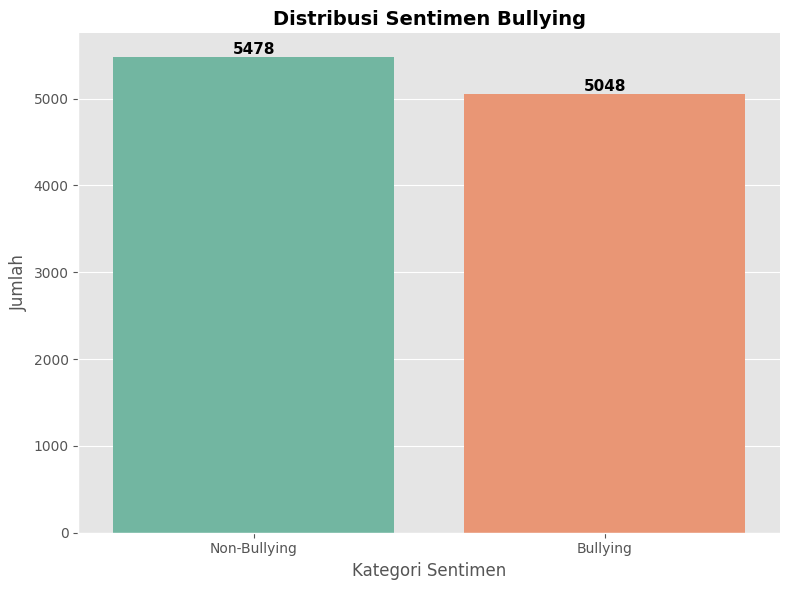

In [5]:
# Ubah label numerik jadi label teks
df['LabelText'] = df['Label'].map({0: 'Non-Bullying', 1: 'Bullying'})

# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='LabelText', palette=['#66c2a5', '#fc8d62'])

# Tambahkan label jumlah di atas bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')

# Tambahan visual
plt.title('Distribusi Sentimen Bullying', fontsize=14, fontweight='bold')
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

# Text Cleaning

In [6]:
def clean_text(text):
    # Konversi ke lowercase
    text = text.lower()
    # Hapus username
    text = re.sub(r'<username>', '', text)
    # Hapus HTML tags
    text = remove_html(text)
    # Hapus URL
    text = remove_url(text)
    # Ganti slang words
    text = replace_slang(text)
    # Handle word elongation
    text = replace_word_elongation(text)
    # Tambahkan spasi di sekitar emoji sebelum konversi
    text = re.sub(r'([\U00010000-\U0010ffff])', r' \1 ', text)  # spasi di antara emoji UTF-8
    # Konversi emoji ke kata
    text = emoji_to_words(text)
    # Tambahkan spasi di antara kata-kata gabungan
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  # Pisah kata jika ada gabungan kata kapital
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^a-z\s]', '', text)
    # Hapus spasi berlebih
    text = ' '.join(text.split())
    return text

# Terapkan pembersihan teks
df['Cleaned_Text'] = df['Text'].apply(clean_text)
df[['Text', 'Cleaned_Text']].head()

,Text,Cleaned_Text
0,cipung baju zumba cu bgt🤏🏼,cipung baju zumba cu banget tanganmenjepit warnakulitcerahsedang
1,Kenapa dia kalo di luar negeri suka pake baju zumba😭,kenapa dia kalo di luar negeri suka pakai baju zumba wajahmenangiskeras
2,bener bener mirip olga,benar benar mirip olga
3,cipung ketemu yuki kato,cipung ketemu yuki kato
4,cipung era baju zumba is back😂,cipung era baju zumba is back wajahgembiraberuraiairmata


# Text Preprocessing (Tokenizing)

In [7]:
def tokenize_text(text):
    return word_tokenize(text)

df['Tokenized_Text'] = df['Cleaned_Text'].apply(tokenize_text)

print("\nHasil Tokenization:")
df[['Cleaned_Text', 'Tokenized_Text']].head()


Hasil Tokenization:


,Cleaned_Text,Tokenized_Text
0,cipung baju zumba cu banget tanganmenjepit warnakulitcerahsedang,"[cipung, baju, zumba, cu, banget, tanganmenjepit, warnakulitcerahsedang]"
1,kenapa dia kalo di luar negeri suka pakai baju zumba wajahmenangiskeras,"[kenapa, dia, kalo, di, luar, negeri, suka, pakai, baju, zumba, wajahmenangiskeras]"
2,benar benar mirip olga,"[benar, benar, mirip, olga]"
3,cipung ketemu yuki kato,"[cipung, ketemu, yuki, kato]"
4,cipung era baju zumba is back wajahgembiraberuraiairmata,"[cipung, era, baju, zumba, is, back, wajahgembiraberuraiairmata]"


# Text Preprocessing (StopWord Removal)

In [8]:
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Hilangkan stopwords
df['No_Stopwords'] = df['Tokenized_Text'].apply(lambda tokens: [w for w in tokens if w not in stopwords])
print("\nHasil Stopword Removal:")
df[['Tokenized_Text', 'No_Stopwords']].head()


Hasil Stopword Removal:


,Tokenized_Text,No_Stopwords
0,"[cipung, baju, zumba, cu, banget, tanganmenjepit, warnakulitcerahsedang]","[cipung, baju, zumba, cu, banget, tanganmenjepit, warnakulitcerahsedang]"
1,"[kenapa, dia, kalo, di, luar, negeri, suka, pakai, baju, zumba, wajahmenangiskeras]","[kalo, luar, negeri, suka, pakai, baju, zumba, wajahmenangiskeras]"
2,"[benar, benar, mirip, olga]","[benar, benar, mirip, olga]"
3,"[cipung, ketemu, yuki, kato]","[cipung, ketemu, yuki, kato]"
4,"[cipung, era, baju, zumba, is, back, wajahgembiraberuraiairmata]","[cipung, era, baju, zumba, is, back, wajahgembiraberuraiairmata]"


# Text Preprocessing (Stemming)

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]

df['Stemmed_Text'] = df['No_Stopwords'].apply(stem_text)
print("\nHasil Stemming:")
df[['No_Stopwords', 'Stemmed_Text']].head()


Hasil Stemming:


,No_Stopwords,Stemmed_Text
0,"[cipung, baju, zumba, cu, banget, tanganmenjepit, warnakulitcerahsedang]","[cipung, baju, zumba, cu, banget, tanganmenjepit, warnakulitcerahsedang]"
1,"[kalo, luar, negeri, suka, pakai, baju, zumba, wajahmenangiskeras]","[kalo, luar, negeri, suka, pakai, baju, zumba, wajahmenangiskeras]"
2,"[benar, benar, mirip, olga]","[benar, benar, mirip, olga]"
3,"[cipung, ketemu, yuki, kato]","[cipung, ketemu, yuk, kato]"
4,"[cipung, era, baju, zumba, is, back, wajahgembiraberuraiairmata]","[cipung, era, baju, zumba, is, back, wajahgembiraberuraiairmata]"


In [10]:
df['Processed_Text'] = df['Stemmed_Text'].apply(lambda x: ' '.join(x))
print("\nTeks Setelah Preprocessing:")
df[['Stemmed_Text', 'Processed_Text']].head()


Teks Setelah Preprocessing:


,Stemmed_Text,Processed_Text
0,"[cipung, baju, zumba, cu, banget, tanganmenjepit, warnakulitcerahsedang]",cipung baju zumba cu banget tanganmenjepit warnakulitcerahsedang
1,"[kalo, luar, negeri, suka, pakai, baju, zumba, wajahmenangiskeras]",kalo luar negeri suka pakai baju zumba wajahmenangiskeras
2,"[benar, benar, mirip, olga]",benar benar mirip olga
3,"[cipung, ketemu, yuk, kato]",cipung ketemu yuk kato
4,"[cipung, era, baju, zumba, is, back, wajahgembiraberuraiairmata]",cipung era baju zumba is back wajahgembiraberuraiairmata


In [ ]:
# df.to_csv('preprocessed_dataset.csv', index=False)
# print("\nDataset yang telah dipreproses disimpan sebagai 'preprocessed_dataset.csv'")


Dataset yang telah dipreproses disimpan sebagai 'preprocessed_dataset.csv'


In [ ]:
# df = pd.read_csv('preprocessed_dataset.csv')
# df.head()

,Text,Label,LabelText,Cleaned_Text,Tokenized_Text,No_Stopwords,Stemmed_Text,Processed_Text
0,cipung baju zumba cu bgt🤏🏼,0,Non-Bullying,cipung baju zumba cu banget tanganmenjepit warnakulitcerahsedang,"['cipung', 'baju', 'zumba', 'cu', 'banget', 'tanganmenjepit', 'warnakulitcerahsedang']","['cipung', 'baju', 'zumba', 'cu', 'banget', 'tanganmenjepit', 'warnakulitcerahsedang']","['cipung', 'baju', 'zumba', 'cu', 'banget', 'tanganmenjepit', 'warnakulitcerahsedang']",cipung baju zumba cu banget tanganmenjepit warnakulitcerahsedang
1,Kenapa dia kalo di luar negeri suka pake baju zumba😭,0,Non-Bullying,kenapa dia kalo di luar negeri suka pakai baju zumba wajahmenangiskeras,"['kenapa', 'dia', 'kalo', 'di', 'luar', 'negeri', 'suka', 'pakai', 'baju', 'zumba', 'wajahmenangiskeras']","['kalo', 'luar', 'negeri', 'suka', 'pakai', 'baju', 'zumba', 'wajahmenangiskeras']","['kalo', 'luar', 'negeri', 'suka', 'pakai', 'baju', 'zumba', 'wajahmenangiskeras']",kalo luar negeri suka pakai baju zumba wajahmenangiskeras
2,bener bener mirip olga,0,Non-Bullying,benar benar mirip olga,"['benar', 'benar', 'mirip', 'olga']","['benar', 'benar', 'mirip', 'olga']","['benar', 'benar', 'mirip', 'olga']",benar benar mirip olga
3,cipung ketemu yuki kato,0,Non-Bullying,cipung ketemu yuki kato,"['cipung', 'ketemu', 'yuki', 'kato']","['cipung', 'ketemu', 'yuki', 'kato']","['cipung', 'ketemu', 'yuk', 'kato']",cipung ketemu yuk kato
4,cipung era baju zumba is back😂,0,Non-Bullying,cipung era baju zumba is back wajahgembiraberuraiairmata,"['cipung', 'era', 'baju', 'zumba', 'is', 'back', 'wajahgembiraberuraiairmata']","['cipung', 'era', 'baju', 'zumba', 'is', 'back', 'wajahgembiraberuraiairmata']","['cipung', 'era', 'baju', 'zumba', 'is', 'back', 'wajahgembiraberuraiairmata']",cipung era baju zumba is back wajahgembiraberuraiairmata


# Train-Test Split (80:20)

In [11]:
X = df['Processed_Text']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nUkuran Data Training:", X_train.shape)
print("Ukuran Data Testing:", X_test.shape)


Ukuran Data Training: (8420,)
Ukuran Data Testing: (2106,)


# Tf-Idf Vectorizer

In [12]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()  # Fit dan transform pada training
X_test_tfidf = tfidf.transform(X_test).toarray()       # Hanya transform pada test

print("\nShape of Training TF-IDF Matrix:", X_train_tfidf.shape)
print("Shape of Testing TF-IDF Matrix:", X_test_tfidf.shape)
print("Feature Names Sample:", tfidf.get_feature_names_out()[:10])


Shape of Training TF-IDF Matrix: (8420, 5000)
Shape of Testing TF-IDF Matrix: (2106, 5000)
Feature Names Sample: ['aal' 'aaliyah' 'abadi' 'abah' 'abang' 'abar' 'abiez' 'about' 'absen'
 'abt']


# Modelling

In [14]:
from tqdm.notebook import tqdm 

# Model yang akan digunakan
models = {
    'Naive Bayes'  : MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

predictions = {}

# Menambahkan tqdm pada loop
for name, mdl in tqdm(models.items(), desc="Training Models", total=len(models)):
    mdl.fit(X_train_tfidf, y_train)  # Melatih model
    predictions[name] = mdl.predict(X_test_tfidf)  # Prediksi hasil


Training Models:   0%|          | 0/2 [00:00<?, ?it/s]

# Model Evaluation

In [15]:
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.autolayout': True,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

def evaluate_and_plot(cm, model_name, labels):
    """Plot Confusion Matrix yang sudah dihitung."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=0.5)
    plt.title(f'Confusion Matrix — {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def print_metrics(y_true, y_pred, model_name, labels):
    """Cetak metrik evaluasi dan classification report."""
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec  = recall_score(y_true, y_pred, average='weighted')
    f1   = f1_score(y_true, y_pred, average='weighted')

    print(f"\n=== {model_name} ===")
    print(f"Akurasi  : {acc:.4f}")
    print(f"Presisi  : {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

def compare_models(metrics_df):
    """Barplot perbandingan metrik antar-model."""
    plt.figure(figsize=(8, 5))
    metrics_melted = metrics_df.melt(id_vars='Model',
                                     var_name='Metric',
                                     value_name='Score')
    ax = sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric')
    ax.set_title('Perbandingan Performansi Model')
    ax.set_ylim(0, 1)
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.2f}", (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9)
    plt.legend(loc='lower right')
    plt.show()

def plot_feature_importance(model, feature_names, top_n=10):
    """Tampilkan Top-N fitur terpenting dari RandomForest."""
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    top_feats = feat_imp.nlargest(top_n).sort_values()
    
    plt.figure(figsize=(6, 5))
    sns.barplot(x=top_feats.values, y=top_feats.index)
    plt.title(f'Top {top_n} Fitur RF')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    for i, v in enumerate(top_feats.values):
        plt.text(v + 0.002, i, f"{v:.3f}", va='center')
    plt.show()


=== Naive Bayes ===
Akurasi  : 0.7958
Presisi  : 0.7964
Recall   : 0.7958
F1-Score : 0.7954

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.83      0.81      1096
    Positive       0.81      0.76      0.78      1010

    accuracy                           0.80      2106
   macro avg       0.80      0.79      0.79      2106
weighted avg       0.80      0.80      0.80      2106



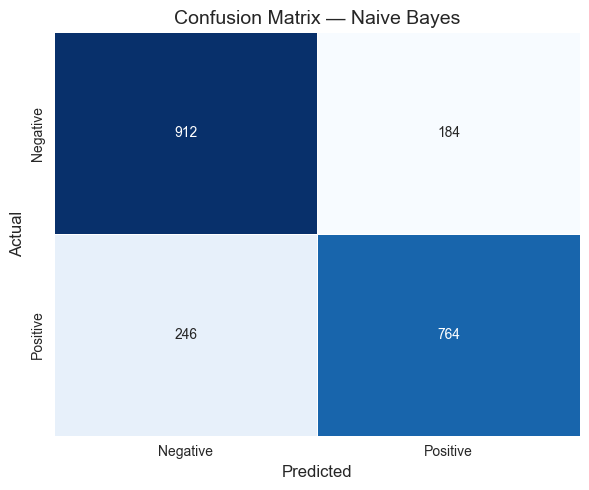


=== Random Forest ===
Akurasi  : 0.7716
Presisi  : 0.7723
Recall   : 0.7716
F1-Score : 0.7717

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.76      0.78      1096
    Positive       0.75      0.78      0.77      1010

    accuracy                           0.77      2106
   macro avg       0.77      0.77      0.77      2106
weighted avg       0.77      0.77      0.77      2106



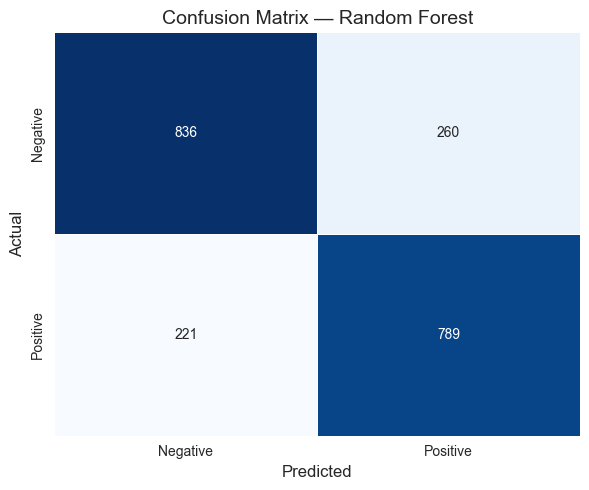

In [16]:
labels = ['Negative', 'Positive']
metrics = []
for name, y_pred in predictions.items():
    print_metrics(y_test, y_pred, name, labels)
    cm = confusion_matrix(y_test, y_pred)
    evaluate_and_plot(cm, name, labels)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec  = recall_score(y_test, y_pred, average='weighted')
    f1   = f1_score(y_test, y_pred, average='weighted')
    metrics.append([name, acc, prec, rec, f1])

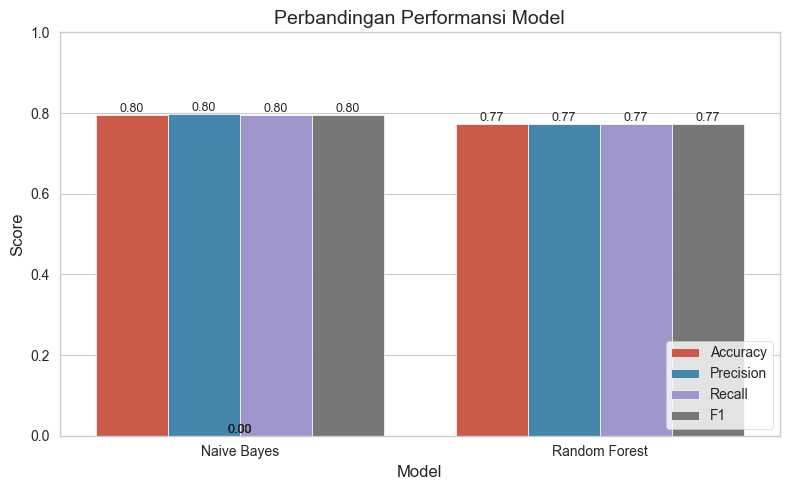

In [17]:
metrics_df = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
compare_models(metrics_df)